- Sentiment analysis has been applied to the Twitter dataset, which was sourced from Kaggle.

- The initial dataset consisted of 1.65 million records, which was further reduced during text preprocessing based on the length of the tweets.

- Implemented models like CBOW (Continuous Bag of Words), Skip-Gram, CountVectorizer, and TF-IDF to predict the sentiment of the tweets.

- Since the dataset is almost balanced, accuracy metrics have been used for model evaluation.

# Importing Dataset and Dependencies

In [1]:
! pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
# import dataset using API from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 99% 80.0M/80.9M [00:02<00:00, 55.9MB/s]
100% 80.9M/80.9M [00:02<00:00, 42.0MB/s]


In [4]:
# extracting the zip file
from zipfile import ZipFile

dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# importin the required libraries

import numpy as np
import pandas as pd
import re
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [7]:
# library to expand short forms

!pip install contractions
import contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 15.5 MB/s eta 0:00:00


In [8]:
# importing the nltk dependencies
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import gensim
from gensim.models import Word2Vec
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [41]:
# importing the datasets
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)

In [42]:
# labelling the columns
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text' ]
df.sample(5)

,target,ids,date,flag,user,text
559431,0,2204974373,Wed Jun 17 03:37:32 PDT 2009,NO_QUERY,HollieChristina,why did my umbrella have to break i got soaked...
341416,0,2015035064,Wed Jun 03 03:29:59 PDT 2009,NO_QUERY,KOODA_BOMB,Goodmornin everyone im on my way 2work agin o...
1179973,4,1981835428,Sun May 31 09:59:30 PDT 2009,NO_QUERY,BulldogRescueNJ,"@ToniPossible @chazdrums No, what's on our we..."
1422426,4,2058498249,Sat Jun 06 15:03:41 PDT 2009,NO_QUERY,concertreviewer,"The Church on 6/11, Donkey Punch on 6/12 KimS..."
268606,0,1989442096,Mon Jun 01 01:33:21 PDT 2009,NO_QUERY,PhotogFishy10,"Sooo tired and exhausted, yet, I can't sleep.."


Content
It contains the following 6 fields:

target: the polarity of the tweet (0 = negative, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

# Data Understanding

In [43]:
# checking datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [44]:
# shape of dataset
orignal_shape = df.shape
orignal_shape

(1600000, 6)

In [45]:
# missing value
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [46]:
# distribution of target
df.target.value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [47]:
# converting target label of 4 to 1, which indicates as positive sentiment
df['target'] = df['target'].apply(lambda x : 1 if x == 4 else 0)

In [48]:
# distribution of dependent variable
df.target.value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

# Text Preprocessing

In [49]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [50]:
# Adding the column containing number of words present in the orignal and cleaned text

df['num_count_text'] = df['text'].apply(lambda x: len(x.split()))

In [51]:
# statistical analysis of the count

df['num_count_text'].describe()

count    1.600000e+06
mean     1.317615e+01
std      6.957978e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      6.400000e+01
Name: num_count_text, dtype: float64

In [52]:
# filtering the tweets which have length more than or equal to median of the dataset
print(df['num_count_text'].median())

# removing the tweets whaving word count less than median count
df = df[df['num_count_text'] >= df['num_count_text'].median()]

12.0


In [53]:
print('Orignal Dataset shape:',orignal_shape[0])
print('Filtered Number of rows:',df.shape[0])
print('Number of rows removed:', orignal_shape[0] - df.shape[0])

Orignal Dataset shape: 1600000
Filtered Number of rows: 851706
Number of rows removed: 748294


In [54]:
# Creating the function for the pre-processing, used the porterstemmer to convert word to its root form

# Initilization of porterstemmer
stemmer = PorterStemmer()

def text_preprocessing(text):
  text = contractions.fix(text) # converting can't to cannot
  text = re.sub(r'@\w+', '', text) # removing the @apple
  text = re.sub(r'http\S+', '', text) # removing the http
  text = re.sub(r"[^a-zA-Z]", " ", text) # removing the numbers
  text = text.lower().strip()
  text = word_tokenize(text)
  text = [stemmer.stem(w) for w in text if not w in stopwords.words('english')]
  text = [token for token in text if len(token) >= 2]
  text = ' '.join(text)

  return text

In [55]:
# applying the preprocessing over

# for 851706 rows it takes 30 mins on gpu

df['cleaned_text'] = df['text'].apply(text_preprocessing)
df.head()

,target,ids,date,flag,user,text,num_count_text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",19,awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,21,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,18,dive mani time ball manag save rest go bound
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",21,behav mad see
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,22,hey long time see ye rain bit bit lol fine thank


In [56]:
# Adding the column containing number of words present in the orignal and cleaned text
df['num_count_cleaned_text'] = df['cleaned_text'].apply(lambda x: len(x.split()))

In [57]:
# understanding the distribution of tweet count over number of words in clean text
df['num_count_cleaned_text'].value_counts().sort_index()

num_count_cleaned_text
0        220
1        181
2        886
3       4938
4      17683
5      44256
6      75905
7      99217
8     107256
9     104363
10     97254
11     85921
12     72801
13     54466
14     38073
15     23615
16     12823
17      6400
18      2967
19      1316
20       619
21       253
22       137
23        54
24        31
25        17
26        11
27         7
28        12
29         3
30        18
31         1
33         1
34         1
Name: count, dtype: int64

In [58]:
# looking at the statistics of the cleaned word count
df['num_count_cleaned_text'].describe()

count    851706.000000
mean          9.462964
std           3.018834
min           0.000000
25%           7.000000
50%           9.000000
75%          12.000000
max          34.000000
Name: num_count_cleaned_text, dtype: float64

In [59]:
# printing the median value of the word count and filtering the tweets which have word count more than median value
print( df['num_count_cleaned_text'].median())
df = df[df['num_count_cleaned_text'] > df['num_count_cleaned_text'].median()]

9.0


In [60]:
df.shape

(396801, 9)

In [61]:
# df.to_csv('cleaned_text_with_396801_records.csv')

In [62]:
# number of datapoints from each group
num_sample = 100000

In [63]:
# taking out samples from each buckets

np.random.seed(42)
df_pos = df[df.target == 1].sample(num_sample)
df_neg = df[df.target == 0].sample(num_sample)

# concatenating the above positive and negative datasets into single dataframe
df_f = pd.concat([df_pos, df_neg], axis = 0)
df_f.sort_index(inplace = True)
df_f = df_f.reset_index(drop = True)
df_f.head()

,target,ids,date,flag,user,text,num_count_text,cleaned_text,num_count_cleaned_text
0,0,1467812964,Mon Apr 06 22:20:22 PDT 2009,NO_QUERY,lovesongwriter,Hollis' death scene will hurt me severely to w...,18,holli death scene hurt sever watch film wri di...,10
1,0,1467818007,Mon Apr 06 22:21:39 PDT 2009,NO_QUERY,Anthony_Nguyen,Bed. Class 8-12. Work 12-3. Gym 3-5 or 6. Then...,22,bed class work gym class anoth day go fli miss...,11
2,0,1467820863,Mon Apr 06 22:22:23 PDT 2009,NO_QUERY,tautao,Broadband plan 'a massive broken promise' http...,15,broadband plan massiv broken promis via www di...,13
3,0,1467821715,Mon Apr 06 22:22:37 PDT 2009,NO_QUERY,deelau,"@andywana Not sure what they are, only that th...",27,sure po much want think trade away compani ass...,11
4,0,1467822522,Mon Apr 06 22:22:49 PDT 2009,NO_QUERY,Jenn_L,Where did u move to? I thought u were already...,24,move thought alreadi sd hmmm random found glad...,11


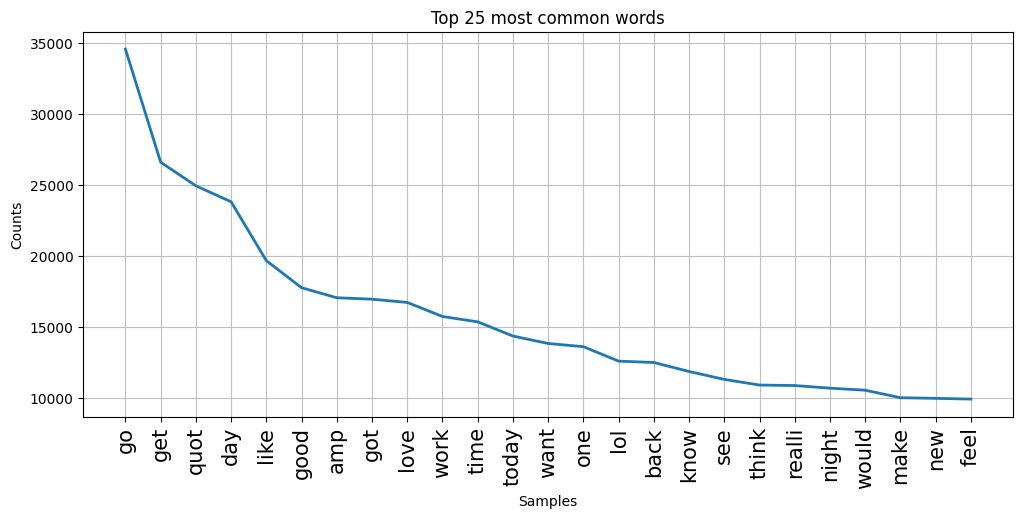

In [64]:
# Create the FreqDist object from the flattened list
frew_distribution = nltk.FreqDist([word for sentence in df_f['cleaned_text'] for word in sentence.split()])

# plotting the graph for most occuring word
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

frew_distribution.plot(25, cumulative=False)

plt.show()

Text(0.5, 1.0, 'num_count_cleaned_text')

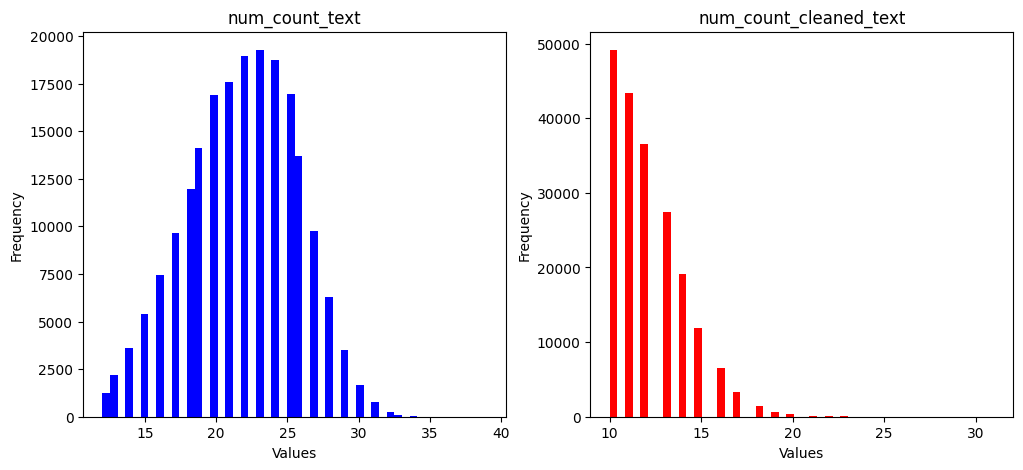

In [65]:
# distribution plot for orignal and cleaned text
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(df_f['num_count_text'], bins = 50, color = 'blue')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('num_count_text')
plt.subplot(1,2,2)
plt.hist(df_f['num_count_cleaned_text'], bins = 50, color = 'red')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('num_count_cleaned_text')

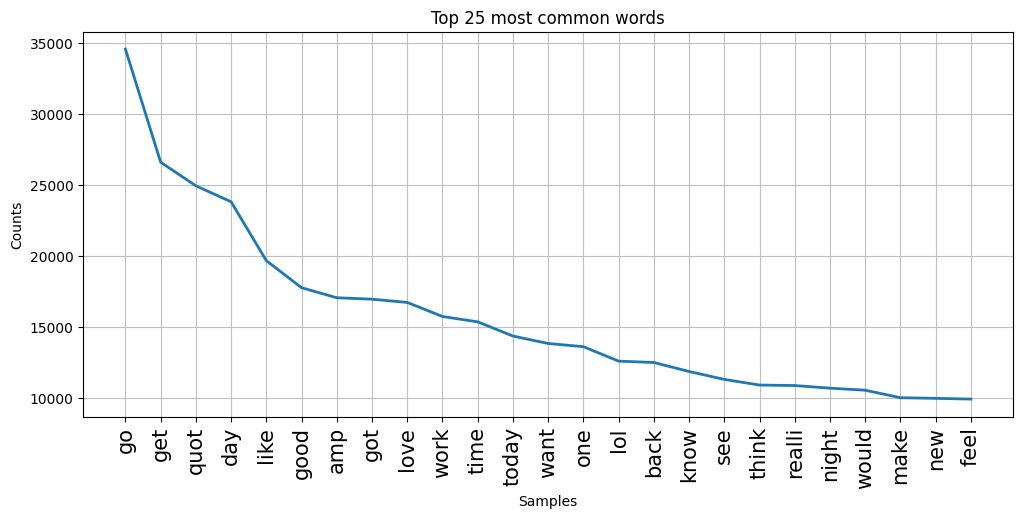

In [67]:
# Frequency distribution of the owrds on the new dataframe
frew_distribution = nltk.FreqDist([word for sentence in df_f['cleaned_text'] for word in sentence.split()])

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)
frew_distribution.plot(25, cumulative=False)

plt.show()

In [68]:
# investigating the tweet which ahe 'go ' word in it
df_f[df_f['cleaned_text'].str.contains('go ')].sample(2)

,target,ids,date,flag,user,text,num_count_text,cleaned_text,num_count_cleaned_text
75325,0,2221711577,Thu Jun 18 05:52:39 PDT 2009,NO_QUERY,VetrinaGirl,@stonedragonfly No... He starting to scratch ...,25,start scratch like crazi poor thing go dr hour...,12
135641,1,1969125692,Fri May 29 23:05:54 PDT 2009,NO_QUERY,JJLuver756,Gonna get off and try to reply to everyone on ...,27,go get tri repli everyon youtub man work inter...,12


In [69]:
df_f['text'].iloc[5]

'@statravelAU just got ur newsletter, those fares really are unbelievable, shame I already booked and paid for mine '

In [70]:
df_f['cleaned_text'].iloc[5]

'got newslett fare realli unbeliev shame alreadi book paid mine'

In [71]:
# saving the sampled file
# df_f.to_csv('cleaned_text_random_sample_200000.csv')

In [ ]:
# df_f = pd.read_csv('cleaned_text_random_sample_200000.csv')

# Model Building

## Word2Vec

#### CBOW Model

In [72]:
# Creating the tokenize list of the tweet

word2vec_list = list(df_f['cleaned_text'].apply(lambda x: x.split()))
word2vec_list[0]

['holli',
 'death',
 'scene',
 'hurt',
 'sever',
 'watch',
 'film',
 'wri',
 'director',
 'cut']

In [73]:
# creating new column with the tokens
df_f['tokenized_text'] = df_f['cleaned_text'].apply(word_tokenize)

In [74]:
# Implementing the gensim model
cbow_model = gensim.models.Word2Vec(word2vec_list, min_count=2, vector_size=100, window=3)

In [75]:
# looking at the vector size
cbow_model.vector_size

100

In [76]:
# This function effectively transforms a document into a single vector that represents the
# average of the word embeddings for the words in the document, providing a numerical
# representation that can be used for various downstream tasks such as classification.

def document_vector(doc):
    # Remove out-of-vocabulary words
    valid_words = [word for word in doc if word in cbow_model.wv]
    if not valid_words:
        return np.zeros(cbow_model.vector_size)

    # Compute average vector
    return np.mean(cbow_model.wv[valid_words], axis=0)

In [77]:
# taking look at the first row
document_vector(df_f['tokenized_text'].values[0])

array([-0.17348066,  0.11082283, -0.06591064,  0.04631888,  0.04161029,
       -0.6576233 ,  0.30269116,  0.5335551 , -0.2543304 , -0.18974446,
       -0.21514182, -0.06914629,  0.39808607, -0.02393884,  0.318636  ,
       -0.27663693,  0.01304342, -0.02978658,  0.03825921, -0.76054657,
        0.10292442,  0.00211972, -0.16200751,  0.06149308, -0.17596944,
        0.36672178, -0.40506393,  0.36807904, -0.8092165 ,  0.00206515,
        0.51468194, -0.39777347,  0.13608727, -0.22239253,  0.14097025,
        0.6130394 , -0.37060708, -0.23678422, -0.14384092, -0.2581272 ,
        0.02660716, -0.41437393, -0.5037851 ,  0.29139748,  0.16582884,
       -0.61265117, -0.44280225, -0.27509946,  0.09283991, -0.15311214,
        0.48445067, -0.05402224, -0.2105939 , -0.16730301,  0.11817802,
        0.16626994,  0.09499739,  0.03004974, -0.42585588,  0.33991185,
        0.13262847, -0.07467853, -0.1268754 , -0.0046838 , -0.1316494 ,
        0.27720714,  0.32665792, -0.08716613, -0.40074342,  0.40

In [78]:
# applyting the above function to the text

X = []
for doc in tqdm(df_f['tokenized_text'].values):
    X.append(document_vector(doc))

100%|██████████| 200000/200000 [00:10<00:00, 19040.63it/s]


In [79]:
# converting X into array
X = np.array(X)

In [80]:
# train test split for CBOW model
X_train, X_test, y_train, y_test = train_test_split(X, df_f['target'], test_size=0.25, stratify=df_f['target'], random_state=100)

In [81]:
# C parameter, for tuning
parameters = {'C' : [0.5, 1, 2.5, 5] }

In [82]:
# implementing Logisticregression model
model_LR_cbow = LogisticRegression(solver='saga', penalty='l1', verbose = 1, n_jobs = -1)

In [83]:
# implementing the cross validation
clf_model_LR_cbow = GridSearchCV(model_LR_cbow, parameters, cv = 5)
clf_model_LR_cbow.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 18 epochs took 6 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 16 epochs took 5 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 18 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 16 epochs took 6 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 19 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 16 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 18 epochs took 5 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 6 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 3 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 16 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 16 epochs took 3 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 5 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 16 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 6 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 18 epochs took 5 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 18 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 4 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 7 seconds


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, penalty='l1',
                                          solver='saga', verbose=1),
             param_grid={'C': [0.5, 1, 2.5, 5]})

In [84]:
# looking at the best model performance
print(clf_model_LR_cbow.best_params_)
print(clf_model_LR_cbow.best_score_)

{'C': 1}
0.6869133333333334


Best Model

In [85]:
# Training model with the best parameters
model_LR_cbow_best = LogisticRegression(solver='saga', penalty='l1', verbose = 1, n_jobs = -1, C =clf_model_LR_cbow.best_params_['C'])
model_LR_cbow_best.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 16 epochs took 4 seconds


LogisticRegression(C=1, n_jobs=-1, penalty='l1', solver='saga', verbose=1)

In [86]:
# checking train accuracy

print('Train accuracy')
cbow_log_train_accuracy = accuracy_score(y_train, model_LR_cbow_best.predict(X_train))
cbow_log_train_accuracy

Train accuracy


0.6875266666666666

In [87]:
# checking test accuracy

print('Test accuracy')
cbow_log_test_accuracy = accuracy_score(y_test, model_LR_cbow_best.predict(X_test))
cbow_log_test_accuracy

Test accuracy


0.68794

In [88]:
# preparing the dataset for results

res = {'Method':['CBOW+Log_Reg_10'],
       'Train_accuracy': [cbow_log_train_accuracy],
       'Test_accuracy':[cbow_log_test_accuracy] }
pd.DataFrame(res)

,Method,Train_accuracy,Test_accuracy
0,CBOW+Log_Reg_10,0.687527,0.68794


#### SKIP-GRAM Model

In [89]:
# using skpgram model
skipgram_model = gensim.models.Word2Vec(word2vec_list, min_count=2, vector_size=100, window=3, sg=1)

In [90]:
skipgram_model.vector_size

100

In [91]:
def document_vector_skip_gram(doc):
    # Remove out-of-vocabulary words
    valid_words = [word for word in doc if word in skipgram_model.wv]
    if not valid_words:
        return np.zeros(skipgram_model.vector_size)

    # Compute average vector
    return np.mean(skipgram_model.wv[valid_words], axis=0)

In [92]:
document_vector_skip_gram(df_f['tokenized_text'].values[0])

array([-0.05898808,  0.06259774, -0.02832376,  0.03844326,  0.05529287,
       -0.49421912,  0.23942213,  0.534223  , -0.20329025, -0.14233407,
        0.02997881, -0.2452114 ,  0.1605162 ,  0.12066264, -0.00659317,
       -0.10363301, -0.03933327, -0.191284  , -0.02836815, -0.48496613,
        0.12079022,  0.00094278, -0.06592984,  0.04592615, -0.00243176,
        0.11567056, -0.109869  ,  0.09404456, -0.37620854, -0.13679889,
        0.26508287, -0.17052458,  0.16192876, -0.10944848,  0.07349651,
        0.4097321 , -0.07481124, -0.24558151, -0.04519424, -0.32003617,
       -0.06409256, -0.18050893, -0.13217221,  0.09602593,  0.1405844 ,
       -0.3050757 , -0.33814105, -0.03409442,  0.2129961 ,  0.05808112,
        0.1569905 , -0.05017678, -0.08340739,  0.02195162, -0.05953579,
        0.17806698,  0.18415566,  0.05530502, -0.30387953,  0.03298208,
       -0.04584294,  0.03110223,  0.04960888,  0.06976224, -0.33212543,
        0.28385967,  0.11841241, -0.00430664, -0.36533993,  0.34

In [93]:
# implementing the skipgram model
X = []
for doc in tqdm(df_f['tokenized_text'].values):
    X.append(document_vector_skip_gram(doc))

100%|██████████| 200000/200000 [00:12<00:00, 16661.67it/s]


In [94]:
# array
X = np.array(X)

In [95]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, df_f['target'], test_size=0.25, stratify=df_f['target'], random_state=100)

In [96]:
# using logistic regression
model_LR_skip_best = LogisticRegression(solver='saga', penalty='l1', verbose = 1, n_jobs = -1)
model_LR_skip_best.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 17 epochs took 5 seconds


LogisticRegression(n_jobs=-1, penalty='l1', solver='saga', verbose=1)

In [97]:
# checking training accuracy

print('Train accuracy')
skipgram_log_train_accuracy = accuracy_score(y_train, model_LR_skip_best.predict(X_train))
skipgram_log_train_accuracy

Train accuracy


0.6895733333333334

In [98]:
# checking test accuracy

print('Test accuracy')
skipgram_log_test_accuracy = accuracy_score(y_test, model_LR_skip_best.predict(X_test))
skipgram_log_test_accuracy

Test accuracy


0.6895

In [99]:
# ataching to the result dataframe

res1 = {'Method':['skip_gram'],
       'Train_accuracy': [skipgram_log_train_accuracy],
       'Test_accuracy':[skipgram_log_test_accuracy] }
pd.DataFrame(res1)

final = pd.concat([pd.DataFrame(res), pd.DataFrame(res1)], ignore_index=True)
final

,Method,Train_accuracy,Test_accuracy
0,CBOW+Log_Reg_10,0.687527,0.68794
1,skip_gram,0.689573,0.68950


#### CountVectorizer

In [100]:
# initilizaton of countvectorizer

CV = CountVectorizer(stop_words = 'english',
                     ngram_range = (1,2),
                     min_df= 5,
                     max_features = 5000 )
CV_features = CV.fit_transform(df_f['cleaned_text'])

In [101]:
CV_features.shape

(200000, 5000)

In [102]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(CV_features, df_f['target'], test_size=0.25, stratify=df_f['target'], random_state=100)

In [103]:
# logistic regression
model_LR_CV_best = LogisticRegression(solver='saga', penalty='l2', C = 1)
model_LR_CV_best.fit(X_train, y_train)

LogisticRegression(C=1, solver='saga')

In [104]:
# checking for training accuracy

print('Train accuracy')
CV_log_train_accuracy = accuracy_score(y_train, model_LR_CV_best.predict(X_train))
CV_log_train_accuracy

Train accuracy


0.75584

In [105]:
# checking for test accuracy

print('Test accuracy')
CV_log_test_accuracy = accuracy_score(y_test, model_LR_CV_best.predict(X_test))
CV_log_test_accuracy

Test accuracy


0.73154

In [106]:
# combining result dataset

res2 = {'Method':['Countvectorizer'],
       'Train_accuracy': [CV_log_train_accuracy],
       'Test_accuracy':[CV_log_test_accuracy] }
pd.DataFrame(res2)

final = pd.concat([pd.DataFrame(final), pd.DataFrame(res2)], ignore_index=True)
final

,Method,Train_accuracy,Test_accuracy
0,CBOW+Log_Reg_10,0.687527,0.68794
1,skip_gram,0.689573,0.68950
2,Countvectorizer,0.755840,0.73154


#### TfidfVectorizer

In [107]:
# implemeting the tfidf vector

tfidf = TfidfVectorizer(stop_words = 'english',
                        ngram_range = (1,2),
                        min_df = 5,
                        max_features=5000 )

tfidf_feature = tfidf.fit_transform(df_f['cleaned_text'])

In [108]:
tfidf_feature.shape

(200000, 5000)

In [109]:
# split
X_train, X_test, y_train, y_test = train_test_split(tfidf_feature, df_f['target'], test_size=0.25, stratify=df_f['target'], random_state=100)

In [110]:
# logistic regression

model_LR_tfidf_best = LogisticRegression(solver='saga', penalty='l1', verbose = 1, n_jobs = -1)
model_LR_tfidf_best.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


max_iter reached after 155 seconds


LogisticRegression(n_jobs=-1, penalty='l1', solver='saga', verbose=1)

In [111]:
# training accuracy

print('Train accuracy')
tidf_log_train_accuracy = accuracy_score(y_train, model_LR_tfidf_best.predict(X_train))
tidf_log_train_accuracy

Train accuracy


0.7542866666666667

In [112]:
# testing accuracy

print('Test accuracy')
tidf_log_test_accuracy = accuracy_score(y_test, model_LR_tfidf_best.predict(X_test))
tidf_log_test_accuracy

Test accuracy


0.73076

In [113]:
# combining results

res4 = {'Method':['tfidf_vectorizer'],
       'Train_accuracy': [tidf_log_train_accuracy],
       'Test_accuracy':[tidf_log_test_accuracy] }
pd.DataFrame(res4)

final = pd.concat([pd.DataFrame(final), pd.DataFrame(res4)], ignore_index=True)
final

,Method,Train_accuracy,Test_accuracy
0,CBOW+Log_Reg_10,0.687527,0.68794
1,skip_gram,0.689573,0.68950
2,Countvectorizer,0.755840,0.73154
3,tfidf_vectorizer,0.754287,0.73076


# Using NLTK SentimentIntensityAnalyzer

In [114]:
# initilization
nltk_sia = SentimentIntensityAnalyzer()

In [115]:
# implemeting model on a sample
nltk_sia.polarity_scores(df_f['cleaned_text'].iloc[0])

{'neg': 0.573, 'neu': 0.427, 'pos': 0.0, 'compound': -0.8555}

In [116]:
# implemeting the model

res = {}
for i, row in tqdm(df_f.iterrows(), total=len(df_f)):
    text = row['cleaned_text']
    myid = row['ids']
    res[myid] = nltk_sia.polarity_scores(text)

100%|██████████| 200000/200000 [00:59<00:00, 3344.66it/s]


In [117]:
# res

In [118]:
# takingout the result into dataframe

nltk_vaders_res = pd.DataFrame(res).T
nltk_vaders_res.head()

,neg,neu,pos,compound
1467812964,0.573,0.427,0.000,-0.8555
1467818007,0.138,0.862,0.000,-0.1531
1467820863,0.205,0.795,0.000,-0.4767
1467821715,0.216,0.419,0.365,0.1280
1467822522,0.000,0.638,0.362,0.6249


In [119]:
# combining two results

nltk_vaders_res = pd.DataFrame(res).T
nltk_vaders_res = nltk_vaders_res.reset_index().rename(columns={'index': 'ids'})
df_f = nltk_vaders_res.merge(df_f, how='right')

In [120]:
# looking at the statistics
df_f.describe()

,ids,neg,neu,pos,compound,target,num_count_text,num_count_cleaned_text
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,1.999799e+09,0.093040,0.691790,0.215169,0.221299,0.500000,21.825565,12.104535
std,1.932760e+08,0.132524,0.193164,0.181358,0.469898,0.500001,3.888634,1.963331
min,1.467813e+09,0.000000,0.000000,0.000000,-0.998500,0.000000,12.000000,10.000000
25%,1.956820e+09,0.000000,0.552000,0.000000,0.000000,0.000000,19.000000,11.000000
50%,2.002243e+09,0.000000,0.685000,0.203000,0.296000,0.500000,22.000000,12.000000
75%,2.177705e+09,0.178000,0.818000,0.345000,0.636900,1.000000,25.000000,13.000000
max,2.329204e+09,1.000000,1.000000,0.929000,0.992800,1.000000,39.000000,31.000000


In [124]:
# the range of the compoound in this nltk library anges between -1 to 1
# so here i'm assuming the boundary as 0, compound value lower than 0 treated as negative and higher than 0 as Positive

df_f['SIA_result'] = df_f['compound'].apply(lambda x: 1 if x > 0 else 0)

In [125]:
# looking at the values
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(df_f['target'], df_f['SIA_result']).ravel()
(tn, fp, fn, tp)

(51734, 48266, 28819, 71181)

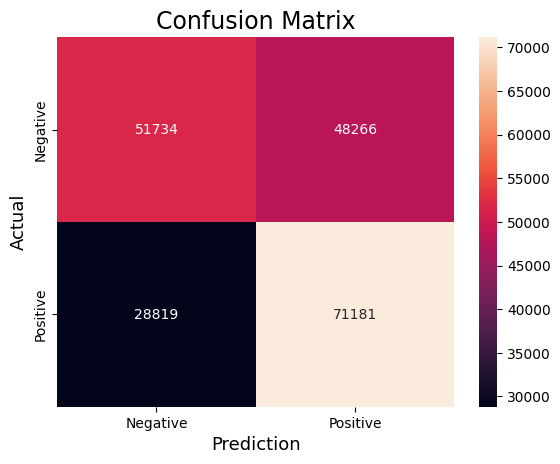

In [127]:
# plotting the confusion matric

cm = sklearn.metrics.confusion_matrix(df_f['target'], df_f['SIA_result'])
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [128]:
# looking at the accuracy
sia_accuracy = accuracy_score(df_f['target'], df_f['SIA_result'])
sia_accuracy

0.614575

In [129]:
# looking at the result dataframe

res5 = {'Method':['SentimentIntensityAnalyzer_overall_accuracy'],
       'Train_accuracy': [sia_accuracy],
       'Test_accuracy':['-'] }


final = pd.concat([pd.DataFrame(final), pd.DataFrame(res5)], ignore_index=True)
final

,Method,Train_accuracy,Test_accuracy
0,CBOW+Log_Reg_10,0.687527,0.68794
1,skip_gram,0.689573,0.6895
2,Countvectorizer,0.755840,0.73154
3,tfidf_vectorizer,0.754287,0.73076
4,SentimentIntensityAnalyzer_overall_accuracy,0.614575,-


# Hugging Face Models

In [131]:
!pip install transformers

In [133]:
!pip install torch

In [132]:
# import transformer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

https://huggingface.co/siebert/sentiment-roberta-large-english?text=%40nationwideclass+no%2C+it%27s+not+behaving+at+all.+i%27m+mad.+why+am+i+here%3F+because+I+can%27t+see+you+all+over+there.


In [135]:
# Extracting the tokenizer from the model
token = AutoTokenizer.from_pretrained('siebert/sentiment-roberta-large-english')

# importing the model
model = AutoModelForSequenceClassification.from_pretrained('siebert/sentiment-roberta-large-english')

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [137]:
# preparing the functions for calculating the sentiment score of the text

def sentimet_score(review):
    pt_tensors = token.encode(review, return_tensors = 'pt')
    res = model(pt_tensors)
    return int(torch.argmax(res.logits))

In [138]:
# looking at the random sample
pt = token.encode('@kevinayP Anything from unison is good   Tp kalo g apa2 y g apa..  Repotin aja..  SMP ma mudah banding UNAS, beda jauhhh', return_tensors = 'pt')

# supplyingt text to model
res = model(pt)

# looking at final sentiment
torch.argmax(res.logits)

tensor(1)

In [139]:
res.logits

tensor([[-3.3807,  2.5688]], grad_fn=<AddmmBackward0>)

In [140]:
# Taking the 1000 random samples from the dataset for implementation of hugging face model

df_hf = df_f.sample(1000)
df_hf.reset_index(drop=True, inplace=True)
df_hf.shape

(1000, 15)

In [141]:
df_hf.target.value_counts()

target
1    510
0    490
Name: count, dtype: int64

In [142]:
# applying the hugging face for the dataset
df_hf['sentiment_huggingface_model'] = df_hf['text'].apply(sentimet_score)

In [143]:
df_hf.sample()

,ids,neg,neu,pos,compound,target,date,flag,user,text,num_count_text,cleaned_text,num_count_cleaned_text,tokenized_text,SIA_result,sentiment_huggingface_model
133,1823686543,0.0,0.682,0.318,0.6369,1,Sat May 16 22:40:25 PDT 2009,NO_QUERY,keysleb,is loving his macbook needs some fancy music s...,16,love macbook need fanci music softwar put thou...,10,"[love, macbook, need, fanci, music, softwar, p...",1,1


In [144]:
# looking at the metrics
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(df_hf['target'], df_hf['sentiment_huggingface_model']).ravel()
(tn, fp, fn, tp)

(337, 153, 97, 413)

In [146]:
# prediction score
sklearn.metrics.precision_score(df_hf['target'], df_hf['sentiment_huggingface_model'])

0.7296819787985865

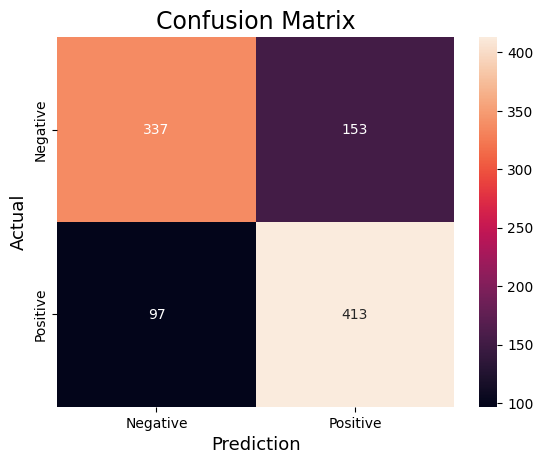

In [147]:
# plotting the confiction metric

cm = sklearn.metrics.confusion_matrix(df_hf['target'], df_hf['sentiment_huggingface_model'])
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negative','Positive'],
            yticklabels=['Negative','Positive'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [148]:
# accuracy score
hf_accuracy = accuracy_score(df_hf['target'], df_hf['sentiment_huggingface_model'])
hf_accuracy

0.75

In [149]:
# printing the result dataframe

res6 = {'Method':['huggingface_overall_accuracy'],
       'Train_accuracy': [hf_accuracy],
       'Test_accuracy':['-'] }
pd.DataFrame(res5)

final = pd.concat([pd.DataFrame(final), pd.DataFrame(res6)], ignore_index=True)
final

,Method,Train_accuracy,Test_accuracy
0,CBOW+Log_Reg_10,0.687527,0.68794
1,skip_gram,0.689573,0.6895
2,Countvectorizer,0.755840,0.73154
3,tfidf_vectorizer,0.754287,0.73076
4,SentimentIntensityAnalyzer_overall_accuracy,0.614575,-
5,huggingface_overall_accuracy,0.750000,-


# LSTM

In [152]:
# Creating the x and y variables for DL models
x_values = df_f['cleaned_text'].values
y_values = df_f['target'].values

In [153]:
# train test split for the x and y variables
x_train , x_test, y_train, y_test = train_test_split(x_values, y_values, stratify= y_values, test_size = 0.2)

In [154]:
# converting to x variables to string format, due to error
x_train = x_train.astype(str)
x_test = x_test.astype(str)

In [155]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras

In [156]:
# Tokenize the train dataset
tokenize = Tokenizer(num_words = 100000)
tokenize.fit_on_texts(x_train)

In [159]:
#  to convert text into sequences of integers, where each integer represents a unique word in the text.
x_train_sequence = tokenize.texts_to_sequences(x_train)

# cinverting the each text into fixed length
x_train_padded = pad_sequences(x_train_sequence, padding='post', maxlen=20)

In [160]:
# implemeting the same method to test data
x_test_sequence = tokenize.texts_to_sequences(x_test)

x_test_padded = pad_sequences(x_test_sequence, padding='post', maxlen=20)

In [161]:
# model initialization
lstm_model = keras.Sequential([
    keras.layers.Embedding(10000, 100, input_length=20),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model
lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1000000   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1087601 (4.15 MB)
Trainable params: 1087601 (4.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [162]:
# setting the epochs
num_epochs = 5

# fitting the model to the dataset
lstm_history = lstm_model.fit(x_train_padded, y_train, epochs=num_epochs, verbose=1, validation_split=0.15)

Epoch 1/5
4250/4250 [==============================] - 106s 24ms/step - loss: 0.5390 - accuracy: 0.7267 - val_loss: 0.5219 - val_accuracy: 0.7435
Epoch 2/5
4250/4250 [==============================] - 54s 13ms/step - loss: 0.4846 - accuracy: 0.7644 - val_loss: 0.5239 - val_accuracy: 0.7402
Epoch 3/5
4250/4250 [==============================] - 35s 8ms/step - loss: 0.4434 - accuracy: 0.7877 - val_loss: 0.5702 - val_accuracy: 0.7349
Epoch 4/5
4250/4250 [==============================] - 34s 8ms/step - loss: 0.3947 - accuracy: 0.8147 - val_loss: 0.6032 - val_accuracy: 0.7268
Epoch 5/5
4250/4250 [==============================] - 34s 8ms/step - loss: 0.3354 - accuracy: 0.8460 - val_loss: 0.7057 - val_accuracy: 0.7178


In [163]:
# Predictions
prediction = lstm_model.predict(x_test_padded)

1250/1250 [==============================] - 5s 3ms/step


In [164]:
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)

# looking at the accuracy of the model
print("Accuracy of prediction on test set : ", accuracy_score(y_test, pred_labels))

Accuracy of prediction on test set :  0.7146


In [167]:
lstm_accuracy = accuracy_score(y_test, pred_labels)
lstm_accuracy

0.7146

In [168]:
# looking at the result dataframe

res7 = {'Method':['LSTM_accuracy'],
       'Train_accuracy': [lstm_accuracy],
       'Test_accuracy':['-'] }
# pd.DataFrame(res5)

final = pd.concat([pd.DataFrame(final), pd.DataFrame(res7)], ignore_index=True)
final

,Method,Train_accuracy,Test_accuracy
0,CBOW+Log_Reg_10,0.687527,0.68794
1,skip_gram,0.689573,0.6895
2,Countvectorizer,0.755840,0.73154
3,tfidf_vectorizer,0.754287,0.73076
4,SentimentIntensityAnalyzer_overall_accuracy,0.614575,-
5,huggingface_overall_accuracy,0.750000,-
6,LSTM_accuracy,0.714600,-


In [169]:
# exporting the results
final.to_csv('sia_accuracy.csv')

# Final Result

In [171]:
final

,Method,Train_accuracy,Test_accuracy
0,CBOW+Log_Reg_10,0.687527,0.68794
1,skip_gram,0.689573,0.6895
2,Countvectorizer,0.755840,0.73154
3,tfidf_vectorizer,0.754287,0.73076
4,SentimentIntensityAnalyzer_overall_accuracy,0.614575,-
5,huggingface_overall_accuracy,0.750000,-
6,LSTM_accuracy,0.714600,-
